<a href="https://colab.research.google.com/github/futaoo/kg-climate-analysis/blob/main/kg_rainfall_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/KGExtension-code/')

Mounted at /content/drive


##Pip Packages

In [ ]:
!pip install kgextension

     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
     |████████████████████████████████| 379 kB 51.0 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 


##Scripts

###Imports

In [ ]:
import kgextension
import pandas as pd
from kgextension.sparql_helper import RemoteEndpoint
from kgextension.sparql_helper import endpoint_wrapper
from kgextension.linking import label_linker
from kgextension.generator import data_properties_generator
from kgextension.generator import unqualified_relation_generator
from kgextension.generator import specific_relation_generator
from kgextension.generator import custom_sparql_generator
from kgextension.linking import dbpedia_spotlight_linker
from kgextension.link_exploration import link_explorer
from kgextension.uri_helper import uri_querier
from kgextension.endpoints import DBpedia


from pandas import DataFrame
from pandas import concat


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier

###Functions

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


def prcp_map(x):
    value = 'yes' if x > 0 else 'no'
    return value

###Prepare data using kgextension

In [ ]:
climate_kg = RemoteEndpoint(url = "http://jresearch.ucd.ie/kg/climate/sparql", timeout=120, requests_per_min=100*60, retries=10, page_size=10000)

In [ ]:
query_obsv = 'PREFIX ca-property: <http://jresearch.ucd.ie/climate-kg/ca/property/> PREFIX sosa: <http://www.w3.org/ns/sosa/> PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> SELECT ?obsv WHERE {?obsv ca-property:sourceStation <http://jresearch.ucd.ie/climate-kg/resource/station/GHCND:EI000003969>; sosa:resultTime ?date. FILTER ((?date>="2019-04-01"^^xsd:date)&&(?date<="2021-04-01"^^xsd:date))}'
df_entities = endpoint_wrapper(endpoint=climate_kg, query=query_obsv)
query_features= 'PREFIX ca-property: <http://jresearch.ucd.ie/climate-kg/ca/property/> PREFIX sosa: <http://www.w3.org/ns/sosa/> SELECT  ?station ?simpleresult  ?date ?datatype WHERE { *obsv* sosa:hasSimpleResult ?simpleresult; sosa:resultTime ?date; ca-property:sourceStation ?station; sosa:hasResult/ca-property:withDataType/ca-property:id ?datatype. }'
df_custom_sparql = custom_sparql_generator(df_entities, "obsv", query_features, endpoint=climate_kg)
df_custom_sparql

In [ ]:
# df_custom_sparql.to_csv('./datasets/climate-features-plus.csv')

In [ ]:
df_air = pd.read_csv('./datasets/air-features-u.csv')
df_climate = pd.read_csv('./datasets/climate-features.csv').pivot(index='date', columns='datatype', values='simpleresult').fillna(0)
# df_climate
df_air

,created_at,Humidity_%,PM2.5_ATM_ug/m3,Pressure_hpa
0,2019-06-01,57.95,13.05,1013.97
1,2019-06-02,51.37,2.18,1001.23
2,2019-06-03,51.49,3.13,1006.51
3,2019-06-04,69.54,7.79,1001.58
4,2019-06-05,67.70,2.38,1001.83
...,...,...,...,...
362,2020-05-28,44.68,10.57,1029.93
363,2020-05-29,37.91,8.45,1023.37
364,2020-05-30,37.19,8.03,1020.37
365,2020-05-31,39.92,15.02,1020.93


In [ ]:
df_merge = pd.merge(df_air, df_climate, left_on="created_at", right_on="date").sort_values(by=['created_at']).reset_index(drop=True)
# df_merge = df_merge[['created_at', 'PM1.0_CF1_ug/m3', 'PM2.5_CF1_ug/m3', 'PM10.0_CF1_ug/m3','Humidity_%', 'PRCP','SNWD','TAVG','TMAX','TMIN']]
df_merge

,created_at,Humidity_%,PM2.5_ATM_ug/m3,Pressure_hpa,PRCP,SNWD,TAVG,TMAX,TMIN
0,2019-06-01,57.95,13.05,1013.97,1.2,0.0,13.3,20.0,7.5
1,2019-06-02,51.37,2.18,1001.23,0.0,0.0,14.9,19.3,13.6
2,2019-06-03,51.49,3.13,1006.51,9.3,0.0,11.5,17.2,8.6
3,2019-06-04,69.54,7.79,1001.58,19.7,0.0,10.4,12.4,7.9
4,2019-06-05,67.70,2.38,1001.83,0.3,0.0,9.9,12.6,8.8
...,...,...,...,...,...,...,...,...,...
362,2020-05-28,44.68,10.57,1029.93,0.0,0.0,15.3,23.3,10.1
363,2020-05-29,37.91,8.45,1023.37,0.0,0.0,15.8,23.5,11.3
364,2020-05-30,37.19,8.03,1020.37,0.0,0.0,14.9,22.0,9.2
365,2020-05-31,39.92,15.02,1020.93,0.0,0.0,14.6,21.5,9.0


In [ ]:
df_refined = df_merge.drop(columns=['created_at','SNWD','TMAX','TMIN','PM2.5'])
df_refined

,Humidity,Pressure,PRCP,TAVG
0,57.95,1013.97,1.2,13.3
1,51.37,1001.23,0.0,14.9
2,51.49,1006.51,9.3,11.5
3,69.54,1001.58,19.7,10.4
4,67.70,1001.83,0.3,9.9
...,...,...,...,...
362,44.68,1029.93,0.0,15.3
363,37.91,1023.37,0.0,15.8
364,37.19,1020.37,0.0,14.9
365,39.92,1020.93,0.0,14.6


In [ ]:
values = df_refined.values
values

array([[  57.95, 1013.97,    1.2 ,   13.3 ],
       [  51.37, 1001.23,    0.  ,   14.9 ],
       [  51.49, 1006.51,    9.3 ,   11.5 ],
       ...,
       [  37.19, 1020.37,    0.  ,   14.9 ],
       [  39.92, 1020.93,    0.  ,   14.6 ],
       [  42.96, 1023.08,    0.  ,   14.4 ]])

###Create the supervised dataset

In [ ]:
df_raw = series_to_supervised(values,2,1)
df_raw

'\\begin{tabular}{lrrrrrrrrrrrr}\n\\toprule\n{} &  var1(t-2) &  var2(t-2) &  var3(t-2) &  var4(t-2) &  var1(t-1) &  var2(t-1) &  var3(t-1) &  var4(t-1) &  var1(t) &  var2(t) &  var3(t) &  var4(t) \\\\\n\\midrule\n2   &      57.95 &    1013.97 &        1.2 &       13.3 &      51.37 &    1001.23 &        0.0 &       14.9 &    51.49 &  1006.51 &      9.3 &     11.5 \\\\\n3   &      51.37 &    1001.23 &        0.0 &       14.9 &      51.49 &    1006.51 &        9.3 &       11.5 &    69.54 &  1001.58 &     19.7 &     10.4 \\\\\n4   &      51.49 &    1006.51 &        9.3 &       11.5 &      69.54 &    1001.58 &       19.7 &       10.4 &    67.70 &  1001.83 &      0.3 &      9.9 \\\\\n5   &      69.54 &    1001.58 &       19.7 &       10.4 &      67.70 &    1001.83 &        0.3 &        9.9 &    52.70 &  1005.92 &      0.2 &     10.2 \\\\\n6   &      67.70 &    1001.83 &        0.3 &        9.9 &      52.70 &    1005.92 &        0.2 &       10.2 &    53.15 &  1005.46 &      0.0 &      9.8 \\\

####enhanced data

In [ ]:
df_raw = series_to_supervised(values,2,1).drop(columns=['var1(t)', 'var2(t)','var4(t)'])
df_raw['var3(t)'] = df_raw['var3(t)'].map(prcp_map)
label_binarizer = preprocessing.LabelBinarizer()
y = label_binarizer.fit_transform(df_raw['var3(t)']).ravel()
X = df_raw.drop(columns='var3(t)')
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)

####only noaa

In [ ]:
df_raw= series_to_supervised(values,2,1).drop(columns=['var1(t-2)', 'var2(t-2)', 'var1(t-1)', 'var2(t-1)','var1(t)', 'var2(t)', 'var4(t)'])
df_raw['var3(t)'] = df_raw['var3(t)'].map(prcp_map)
label_binarizer = preprocessing.LabelBinarizer()
y = label_binarizer.fit_transform(df_raw['var3(t)']).ravel()
X = df_raw.drop(columns='var3(t)')
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)

####create training set

In [ ]:
label_binarizer = preprocessing.LabelBinarizer()
y = label_binarizer.fit_transform(df_raw['var3(t)']).ravel()
X = df_raw.drop(columns='var3(t)')
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)

###Build the model

####Set the plot

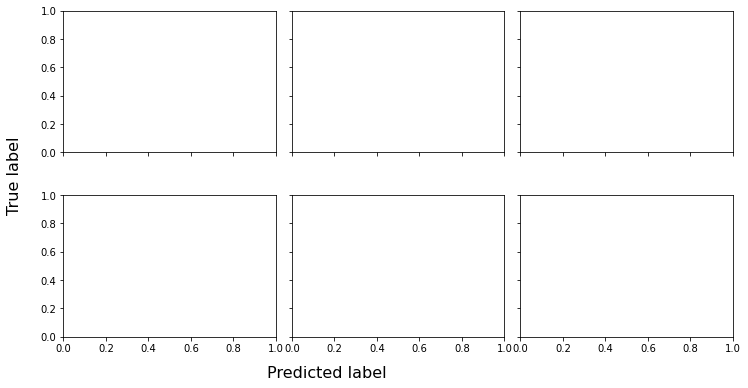

In [ ]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 6))
fig.text(0.43, 0.03, 'Predicted label', ha='center',fontdict={'fontsize': 16})
fig.text(0.06, 0.5, 'True label', va='center', rotation='vertical', fontdict={'fontsize': 16})

plt.subplots_adjust(wspace=0.075, 
                    hspace=0.3)


####Random Forest Classifier

#####NOAA & Link-Climate

              precision    recall  f1-score   support

          no       0.70      0.64      0.67        50
         yes       0.76      0.80      0.78        71

    accuracy                           0.74       121
   macro avg       0.73      0.72      0.72       121
weighted avg       0.73      0.74      0.73       121



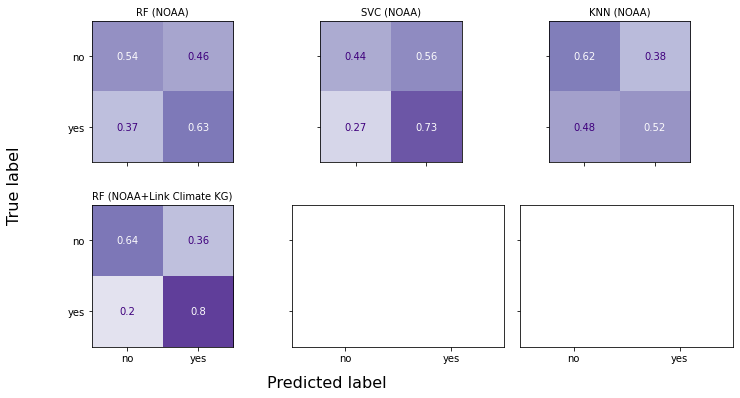

In [ ]:
# clf = RandomForestClassifier(random_state=1235).fit(X_train, y_train)
# y_pred = clf.predict(X_test)

# print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
# ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=label_binarizer.classes_).plot()
# plt.show()

clf = RandomForestClassifier(random_state=1235).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_binarizer.classes_)
disp.plot(ax=axes[1,0],cmap='Purples')
disp.ax_.get_images()[0].set_clim(0,1)
disp.ax_.set_title('RF (NOAA+Link Climate KG)',fontdict={'fontsize': 10})
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('')


# fig.colorbar(disp.im_, ax=axes)

fig

#####NOAA

              precision    recall  f1-score   support

          no       0.51      0.54      0.52        50
         yes       0.66      0.63      0.65        71

    accuracy                           0.60       121
   macro avg       0.59      0.59      0.59       121
weighted avg       0.60      0.60      0.60       121



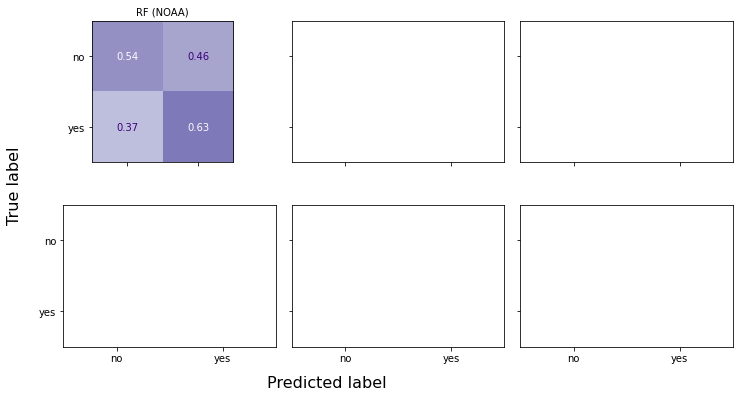

In [ ]:
clf = RandomForestClassifier(random_state=1235).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_binarizer.classes_)
disp.plot(ax=axes[0,0],cmap='Purples')
disp.ax_.get_images()[0].set_clim(0,1)
disp.ax_.set_title('RF (NOAA)',fontdict={'fontsize': 10})
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('')

# plt.subplots_adjust(wspace=0.40, hspace=0.1)
# fig.colorbar(disp.im_, ax=axes)

fig

####Support Vector Classifier

#####NOAA & Link-Climate

              precision    recall  f1-score   support

          no       0.67      0.48      0.56        50
         yes       0.69      0.83      0.76        71

    accuracy                           0.69       121
   macro avg       0.68      0.66      0.66       121
weighted avg       0.68      0.69      0.67       121



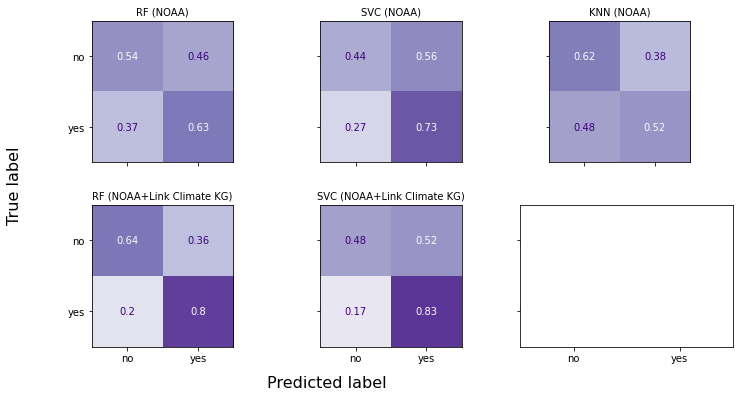

In [ ]:
clf = SVC(gamma=0.01)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_binarizer.classes_)
disp.plot(ax=axes[1,1],cmap='Purples')
disp.ax_.get_images()[0].set_clim(0,1)
disp.ax_.set_title('SVC (NOAA+Link Climate KG)',fontdict={'fontsize': 10})
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('')


# fig.colorbar(disp.im_, ax=axes)

fig

#####NOAA

              precision    recall  f1-score   support

          no       0.54      0.44      0.48        50
         yes       0.65      0.73      0.69        71

    accuracy                           0.61       121
   macro avg       0.59      0.59      0.59       121
weighted avg       0.60      0.61      0.60       121



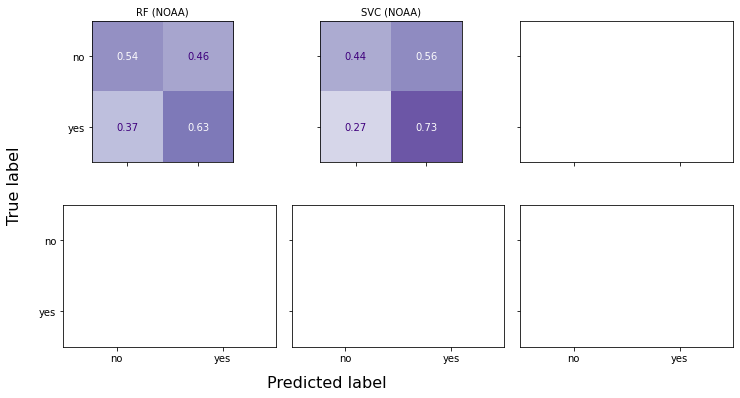

In [ ]:
clf = SVC(gamma=0.01)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_binarizer.classes_)
disp.plot(ax=axes[0,1],cmap='Purples')
disp.ax_.get_images()[0].set_clim(0,1)
disp.ax_.set_title('SVC (NOAA)', fontdict={'fontsize': 10})
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('')

# plt.subplots_adjust(wspace=0.40, hspace=0.1)
# fig.colorbar(disp.im_, ax=axes)

fig

####KNN-Classifier

#####NOAA & Link-Climate

              precision    recall  f1-score   support

          no       0.58      0.74      0.65        50
         yes       0.77      0.62      0.69        71

    accuracy                           0.67       121
   macro avg       0.68      0.68      0.67       121
weighted avg       0.69      0.67      0.67       121



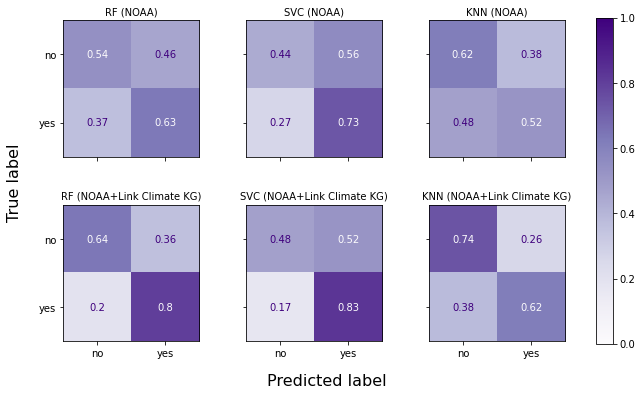

In [ ]:
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_binarizer.classes_)
disp.plot(ax=axes[1,2],cmap='Purples')
disp.ax_.get_images()[0].set_clim(0,1)
disp.ax_.set_title('KNN (NOAA+Link Climate KG)',fontdict={'fontsize': 10})
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('')


fig.colorbar(disp.im_, ax=axes)

fig

In [ ]:
fig.savefig('./pictures/results.png',dpi=200)

#####NOAA

              precision    recall  f1-score   support

          no       0.48      0.62      0.54        50
         yes       0.66      0.52      0.58        71

    accuracy                           0.56       121
   macro avg       0.57      0.57      0.56       121
weighted avg       0.58      0.56      0.56       121



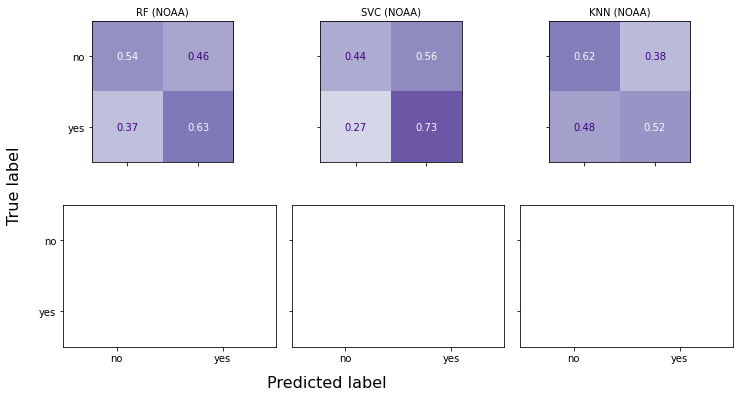

In [ ]:
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_binarizer.classes_)
disp.plot(ax=axes[0,2],cmap='Purples')
disp.ax_.get_images()[0].set_clim(0,1)
disp.ax_.set_title('KNN (NOAA)',fontdict={'fontsize': 10})
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('')

# plt.subplots_adjust(wspace=0.40, hspace=0.1)
# fig.colorbar(disp.im_, ax=axes)

fig

###Entity link using kgextension

Prefix dictionary:

In [ ]:
prefixes = {'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
            'xsd': 'http://www.w3.org/2001/XMLSchema#',
            'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
            'qudt': 'http://qudt.org/1.1/schema/qudt#',
            'prov': 'http://www.w3.org/ns/prov',
            'sosa': 'http://www.w3.org/ns/sosa/',
            'geo': 'http://www.w3.org/2003/01/geo/wgs84_pos#',
            'ca-property': 'http://jresearch.ucd.ie/climate-kg/ca/property/'
            }

---

In [ ]:
df_noaa = pd.read_csv("./datasets/noaa.csv")
df_station = df_noaa.iloc[0:1, 0:4][['STATION','NAME']]
df_noaa.fillna(0.0)

,STATION,NAME,DATE,PRCP,SNWD,TAVG,TMAX,TMIN
0,EI000003969,"DUBLIN PHOENIX PARK, EI",2019-06-01,1.2,0.0,13.3,20.0,7.5
1,EI000003969,"DUBLIN PHOENIX PARK, EI",2019-06-02,0.0,0.0,14.9,19.3,13.6
2,EI000003969,"DUBLIN PHOENIX PARK, EI",2019-06-03,9.3,0.0,11.5,17.2,8.6
3,EI000003969,"DUBLIN PHOENIX PARK, EI",2019-06-04,19.7,0.0,10.4,12.4,7.9
4,EI000003969,"DUBLIN PHOENIX PARK, EI",2019-06-05,0.3,0.0,9.9,12.6,8.8
...,...,...,...,...,...,...,...,...
362,EI000003969,"DUBLIN PHOENIX PARK, EI",2020-05-28,0.0,0.0,15.3,23.3,10.1
363,EI000003969,"DUBLIN PHOENIX PARK, EI",2020-05-29,0.0,0.0,15.8,23.5,11.3
364,EI000003969,"DUBLIN PHOENIX PARK, EI",2020-05-30,0.0,0.0,14.9,22.0,9.2
365,EI000003969,"DUBLIN PHOENIX PARK, EI",2020-05-31,0.0,0.0,14.6,21.5,9.0


In [ ]:
df_spotlight_linked = dbpedia_spotlight_linker(
    df_station, column = "NAME", new_attribute_name="place_at_DBpedia", max_hits=1,
    language="en", selection="first", confidence=0.5, support=5,
    min_similarity_score=0.5
)


DBpedia Spotlight Linker: Querying DSL:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_spotlight_linked

,STATION,NAME,place_at_DBpedia
0,EI000003969,"DUBLIN PHOENIX PARK, EI",http://dbpedia.org/resource/Phoenix_Park


In [ ]:
# df_link_explored = link_explorer(
#     df_spotlight_linked, base_link_column='place_at_DBpedia',number_of_hops=1,
#     lod_sources=['dbpedia'],
#     links_to_follow=['dbo:location']
# )
query_geo_info = "select ?in_city ?latitude ?longitude where {*place_at_DBpedia* dbo:location ?in_city; geo:lat ?latitude; geo:long ?longitude .}"
df_custom_sparql = custom_sparql_generator(df_spotlight_linked, "place_at_DBpedia", query_geo_info, endpoint=DBpedia, prefix_lookup=True)

Row:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_custom_sparql
# df_custom_sparql.reset_index(drop=True).to_latex()

,STATION,NAME,place_at_DBpedia,in_city,latitude,longitude
0,EI000003969,"DUBLIN PHOENIX PARK, EI",http://dbpedia.org/resource/Phoenix_Park,http://dbpedia.org/resource/Dublin,53.36,-6.33


In [ ]:
link_climate = RemoteEndpoint(url = "http://jresearch.ucd.ie/kg/air-pollutants", timeout=120, requests_per_min=100*60, retries=10, page_size=10000)

In [ ]:
query_sensor = "prefix geo: <http://www.w3.org/2003/01/geo/wgs84_pos#> select ?sensor ?in_city ?lat ?lon where {?sensor <http://jresearch.ucd.ie/climate-kg/ca/property/isLocatedIn>"+"<"+df_custom_sparql['in_city'].astype(str).iloc[0]+">; geo:lat ?lat; geo:long ?lon; <http://jresearch.ucd.ie/climate-kg/ca/property/isLocatedIn> ?in_city }"
df_entities = endpoint_wrapper(endpoint=link_climate, query=query_sensor)
# df_custom_sparql = custom_sparql_generator(df_link_explored, "http://dbpedia.org", query, endpoint=air_kg, q)

In [ ]:
pd.set_option('display.max_colwidth',100)
df_entities.to_latex()

'\\begin{tabular}{lllll}\n\\toprule\n{} &                                                         sensor &                             in\\_city &        lat &        lon \\\\\n\\midrule\n0 &   http://jresearch.ucd.ie/climate-kg/purpleair/sensor?id=26695 &  http://dbpedia.org/resource/Dublin &  53.360861 &  -6.273795 \\\\\n1 &  http://jresearch.ucd.ie/climate-kg/purpleair/sensor?id=105508 &  http://dbpedia.org/resource/Dublin &   53.33499 &  -6.216279 \\\\\n2 &   http://jresearch.ucd.ie/climate-kg/purpleair/sensor?id=59111 &  http://dbpedia.org/resource/Dublin &  53.301456 &  -6.258461 \\\\\n3 &   http://jresearch.ucd.ie/climate-kg/purpleair/sensor?id=91889 &  http://dbpedia.org/resource/Dublin &  53.381096 &   -6.06105 \\\\\n\\bottomrule\n\\end{tabular}\n'